In [1]:
import numpy as np
from scipy.special import factorial
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib import collections  as mc
import seaborn as sns
import pandas as pd
style.use('ggplot')

# Geometry Generation Functions

In [2]:
### Multi-Index Functions

def miFactorial(alpha):
    return factorial(alpha).prod()


def miBinomial(alpha, beta):
    return (miFactorial(alpha) 
            /(miFactorial(beta)*miFactorial(alpha - beta)))

In [3]:
def normal(x, partialPsi):
    dx = partialPsi(x, np.array([1, 0]))
    dy = partialPsi(x, np.array([0, 1]))
    return (np.array([dx, dy])/(np.sqrt(dx**2 + dy**2))).T

### Compute Derivatives of Normal ###
def partialL(P, points, partialPsi, L):
    # Initialize Quantities
    partial_l = np.zeros(len(points))
    for dim in range(1, D + 1):
        e = np.zeros(D)
        e[dim - 1] = 1
        Q = (P - e).astype(int)
        for r1 in range(Q[0] + 1):
            for r2 in range(Q[1] + 1):
                ### Loop Structure Hard Coded for D = 2
                R = np.array([r1, r2])
                binom = miBinomial(Q, R)
                partial_l += binom*partialN(R, dim, points, partialPsi, L)*partialPsi(points, Q - R + 2*e)
    return partial_l
 
    
def partialN(P, d, points, partialPsi, L):
    ## Base Case
    if np.array_equal(P, np.array([0, 0])):
        return (normal(points, partialPsi))[:, d - 1]
    e = np.zeros(D)
    e[d - 1] = 1
    deriv_sums = np.zeros(len(points))
    for q1 in range(P[0] + 1):
        for q2 in range(P[1] + 1):
            ### Loop Structure Hard Coded for D=2 
            Q = np.array([q1, q2])
            if np.array_equal(Q, P):
                continue
            binom = miBinomial(P, Q)
            deriv_sums += binom*partialL(P - Q, points, partialPsi, L)*partialN(Q, d, points, partialPsi, L)
    partial_n = partialPsi(points, P + e) - deriv_sums
    return partial_n/L(points)               

## Main Algorithm

#### 0. Compute Derivatives of the Normal

In [4]:
def setup_normals(Q, num_cells, partialPsi, L):
    normal_derivatives = np.zeros([Q+1, Q+1, num_cells, 2])
    for q_mag in range(Q, -1, -1):
        for q1 in range(q_mag+1):
            q = np.array([q1, q_mag - q1])
            normal_derivatives[q1, q_mag - q1, :, 0] = partialN(q, 1, points, partialPsi, L)
            normal_derivatives[q1, q_mag - q1, :, 1] = partialN(q, 2, points, partialPsi, L)
    return normal_derivatives

##### 1. Compute One-Dimensional Moments $M_{V, 1}^q$

In [5]:
def compute_1d_moments(num_cells, points, h, intersection, type='line'):
    # Sets Up Volume Fraction for Edges of Cells
    # left, upper, right, lower

    vol_frac_1d = np.zeros([num_cells, 4])
    # Iterate Through Cells
    for cell in range(num_cells):
        # Center point
        center = points[cell]
        # Find values at corners
        ll = center + np.array([-h/2, -h/2])
        ul = center + np.array([-h/2, h/2])
        ur = center + np.array([h/2, h/2])
        lr = center + np.array([h/2, -h/2])
        corners = np.array([ll, ul, ur, lr])
        if type == 'circle':
            inside = corners[:, 0]**2 + corners[:, 1]**2 < 1
            inside_inclusive = corners[:, 0]**2 + corners[:, 1]**2 <= 1
            outside_inclusive = corners[:, 0]**2 + corners[:, 1]**2 >= 1
        if type == 'line':
            # Hard coding for line x=y
            inside = corners[:, 0] > corners[:, 1]
            inside_inclusive = corners[:, 0] >= corners[:, 1]
            outside_inclusive = corners[:, 0] <= corners[:, 1]
        # Determine If Cell is Inside/Outside/Boundary
        # Note: This ignores a lot of edge/corner cases. Need to Revisit. 
        if inside_inclusive.all(): # cell entirely in boundary
            vol_frac_1d[cell, :] = h
        elif outside_inclusive.all(): # cell entirely outside boundary
            pass
        else: # boundary intersects cell
            # If Boundary Determine which edges intersect Boundary
            for i in range(4):
                if inside[i] == inside[(i+1)%4]: # no change from corner to corner
                    vol_frac_1d[cell, i] = int(inside[i])
                else: # change indicating boundary passes through
                    # is this edge vertical or horizontal?
                    if (corners[i] - corners[(i+1)%4])[0] == 0: # horizontal
                        # find the intersection of x=corners[i, 0]
                        y = intersection(corners[i, 0])
                        if type == 'circle':
                            if corners[i, 1] < 0:
                                y = -y
                        frac = np.abs(y - corners[i, 1])
                        if inside[i]:
                            vol_frac_1d[cell, i] = frac
                        else:
                            vol_frac_1d[cell, i] = h - frac
                    else: # vertical
                        # find the intersection of y=corners[i, 1]
                        x = intersection(corners[i, 1])
                        if type == 'circle':
                            if corners[i, 0] < 0:
                                x = -x
                        frac = np.abs(x - corners[i, 0])
                        if inside[i]:
                            vol_frac_1d[cell, i] = frac
                        else:
                            vol_frac_1d[cell, i] = h - frac
    return vol_frac_1d

In [6]:
def d_integral(beginning, end, q, index, fixed_value):
    next_plus = q[(index+1)%2] + 1
    return fixed_value**q[index]*(1/(next_plus))*(end**next_plus - beginning**next_plus)

#### 2. Irregular One-Dimensional Moments $M_{B, 1}^q$ Are 0 

#### 3. Main Loop

In [7]:
def calc_d(bd_length, fixed_value, h, cell_center, q, d, which_d, type='circle'):
    d_op = (d+1)%2
    if bd_length == h:
        d_pm = d_integral(cell_center[d_op] - h/2, cell_center[d_op] + h/2, q, d, fixed_value)
    elif bd_length > 0:
        # check points
        corner = cell_center + np.array([h/2, h/2])*which_d
        if type == 'circle':
            intersection = circleIntersection(fixed_value)
            if corner[d_op] < 0:
                intersection = -intersection
            if np.sum(corner**2) <= 1: # upper corner is inside
                d_pm = d_integral(intersection, corner[d_op], q, d, fixed_value)
            else: # lower corner is inside
                d_pm = d_integral(corner[d_op] - h, intersection, q, d, fixed_value)
        elif type == "line":
            if corner[0] >= corner[1]:
                d_pm = d_integral(lineIntersection(fixed_value), corner[d_op], q, d, fixed_value)
            else:
                d_pm = d_integral(corner[d_op] - h, lineIntersection(fixed_value), q, d, fixed_value)
    else: d_pm = 0
    return d_pm

In [8]:
def main(Q, num_cells, vol_frac_1d, points, h, normal_derivatives, type='line'):
    volume_moments = np.zeros((Q+1, Q+1, num_cells))
    boundary_moments = np.zeros((Q+1, Q+1, num_cells))
    for cell in range(num_cells):
        for q_mag in range(Q, -1, -1):
            rho = []
            full_lhs = []

            for q1 in range(q_mag+1):
                q = np.array([q1, q_mag - q1])
                for d in range(2):
                    e = np.zeros(2)
                    e[d] = 1
                    

                    # Set d_plus and d_minus
                    if d == 0:
                        # calculate d_plus
                        ptve_bd_length = vol_frac_1d[cell, 2]
                        fixed_ptve_x = points[cell, 0] + h/2
                        d_plus = calc_d(ptve_bd_length, fixed_ptve_x, h, points[cell], q, d, np.array([1, 1]), 
                                        type=type)

                        # calculate d_minus
                        ntve_bd_length = vol_frac_1d[cell, 0]
                        fixed_ntve_x = points[cell, 0] - h/2
                        d_minus = calc_d(ntve_bd_length, fixed_ntve_x, h, points[cell], q, d, np.array([-1, 1]),
                                        type=type)
                    
                    elif d == 1:
                        # calculate d_plus
                        ptve_bd_length = vol_frac_1d[cell, 1]
                        fixed_ptve_y = points[cell, 1] + h/2
                        d_plus = calc_d(ptve_bd_length, fixed_ptve_y, h, points[cell], q, d, np.array([1, 1]),
                                       type=type)

                        # calculate d_minus
                        ntve_bd_length = vol_frac_1d[cell, 3]
                        fixed_ntve_y = points[cell, 1] - h/2
                        d_minus = calc_d(ntve_bd_length, fixed_ntve_y, h, points[cell], q, d, np.array([1, -1]),
                                        type=type)

                    s_sum = 0
                    S = Q - q_mag
                    for s1 in range(S+1):
                        for s2 in range(S+1):
                            s = np.array([s1, s2])
                            if s.sum() >= S:
                                continue
                            elif s.sum() < 1:
                                continue
                            s_sum += normal_derivatives[s1, s2, cell, d]*boundary_moments[q[0]+s1, q[1]+s2, cell]
                    lhs = np.zeros(2*q_mag + 1)
                    q_minus_e = q - e
                    if (q_minus_e >= 0).all(): # Throwing Away qs with negative values
                        lhs[int(q_minus_e[0])] = q[d]
                    # M_B Unknowns (stored based on value of q[0])
                    lhs[q_mag + q[0]] = -normal_derivatives[0, 0, cell, d]


                    full_lhs.append(lhs)
                    rho.append(d_plus - d_minus + s_sum)

            # Solve For MV, MB
            v_and_b = np.linalg.lstsq(np.array(full_lhs), np.array(rho), rcond=None)

            # Unpack v and b               
            values = v_and_b[0]
            for i in range(q_mag):
                volume_moments[i, q_mag - 1 - i, cell] = values[i]
            for i in range(q_mag+1):
                boundary_moments[i, q_mag - i, cell] = values[q_mag + i]
    return volume_moments, boundary_moments

# Problem Set Up

The boundary equation is the zero level set of $\psi(\mathbf{x})$
$$ \psi( \mathbf{x} ) = x_1^2 + x_2^2 - 1 $$

In [9]:
### Global Variables ###
D = 2


### HARD CODED FOR PSI(X) = X^2 + Y^2 - 1 ###########
def partialPsiCircle(x, order):
    if np.array_equal(order, np.array([0, 0])):
        return x[:, 0]**2 + x[:, 1]**2 - 1
    elif np.array_equal(order, np.array([1, 0])) or np.array_equal(order, np.array([0, 1])):
        return 2*(order[0]*x[:, 0] + order[1]*x[:, 1])
    elif np.array_equal(order, np.array([2, 0])) or np.array_equal(order, np.array([0, 2])):
        return 2*np.ones(len(x))
    else:
        return 0*np.ones(len(x))


def circleL(x):
    return 2*np.sqrt(x[:, 0]**2 + x[:, 1]**2)


def circleIntersection(x):
    return np.sqrt(1 - x**2)
#################################################### 

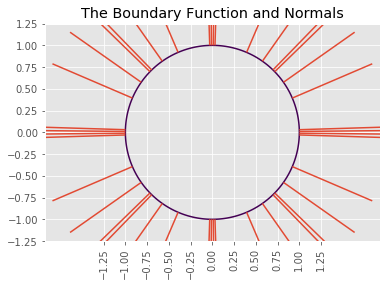

In [10]:
# Set Up Function
x = np.linspace(-1.0, 1.0, 100)
y = np.linspace(-1.0, 1.0, 100)
X, Y = np.meshgrid(x,y)
F = X**2 + Y**2 - 1

# Calculate Normals
level_zero = np.column_stack((X[np.abs(F) <= .001], Y[np.abs(F) <= .001]))
normals = normal(level_zero, partialPsiCircle)
ends = normals + level_zero
list_zero = list(zip(level_zero[:, 0], level_zero[:, 1]))
list_ends = list(zip(ends[:, 0], ends[:, 1]))
points = [[list_zero[i], list_ends[i]] for i in range(len(level_zero))]

fig, ax = plt.subplots()
plt.contour(X,Y,F,[0])
plt.grid(True)
plt.xticks(np.linspace(-1.25, 1.25, 11), rotation='vertical')
plt.yticks(np.linspace(-1.25, 1.25, 11))
plt.axis('equal')
plt.axis((-1.25,1.25,-1.25,1.25))
plt.title("The Boundary Function and Normals")

# Plot Normals
line_segments = mc.LineCollection(points)
ax.add_collection(line_segments)
plt.show()

In [11]:
# Cell Centers
h = .25
a = -1.125
b = 1.125
x = np.linspace(a, b, 10)
y = np.linspace(a, b, 10)
X, Y = np.meshgrid(x,y)
points = np.array(list(zip(X.flatten(), Y.flatten())))
num_cells = len(points)

In [39]:
# Global Variables
Q = 1

In [40]:
# Setup Normals
normal_derivatives = setup_normals(Q, num_cells, partialPsiCircle, circleL)
# Compute 1d Moments
vol_frac_1d = compute_1d_moments(num_cells, points, h, circleIntersection, type="circle")
# Main Loop
volume_moments_circle, boundary_moments = main(Q, num_cells, vol_frac_1d, points, h, normal_derivatives, type='circle')

In [41]:
volume_moments_circle[0, 0, :].sum()

3.105631869268395

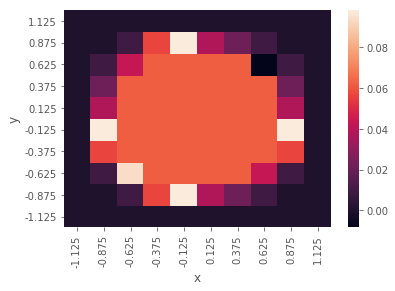

In [42]:
data = {'x': points[:, 0], 'y': points[:, 1], 'area': volume_moments_circle[0, 0]}
df = pd.DataFrame(data=data)
pivot = df.pivot(index='y', columns='x', values='area')
ax = sns.heatmap(pivot)
ax.invert_yaxis()

# Problem 2 Setup

The boundary equation is the zero level set of $\psi(\mathbf{x})$
$$ \psi( \mathbf{x} ) = y - x $$

In [18]:
Q = 1
### HARD CODED FOR PSI(X, Y) = Y - X ###########
def partialPsiLine(x, order):
    if np.array_equal(order, np.array([0, 0])):
        return x[:, 1] - x[:, 0] 
    elif np.array_equal(order, np.array([1, 0])) or np.array_equal(order, np.array([0, 1])):
        return order[1]*np.ones(len(x)) - order[0]*np.ones(len(x))
    else:
        return 0*np.ones(len(x))


def lineL(x):
    return np.sqrt(x[:, 1]**2 - x[:, 0]**2)


def lineIntersection(x):
    return x
#################################################### 

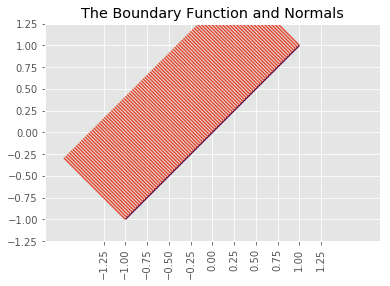

In [19]:
# Set Up Function
x = np.linspace(-1.0, 1.0, 100)
y = np.linspace(-1.0, 1.0, 100)
X, Y = np.meshgrid(x,y)
F = Y - X

# Calculate Normals
level_zero = np.column_stack((X[np.abs(F) <= .001], Y[np.abs(F) <= .001]))
normals = normal(level_zero, partialPsiLine)
ends = normals + level_zero
list_zero = list(zip(level_zero[:, 0], level_zero[:, 1]))
list_ends = list(zip(ends[:, 0], ends[:, 1]))
points = [[list_zero[i], list_ends[i]] for i in range(len(level_zero))]

fig, ax = plt.subplots()
plt.contour(X,Y,F,[0])
plt.grid(True)
plt.xticks(np.linspace(-1.25, 1.25, 11), rotation='vertical')
plt.yticks(np.linspace(-1.25, 1.25, 11))
plt.axis('equal')
plt.axis((-1.25,1.25,-1.25,1.25))
plt.title("The Boundary Function and Normals")

# Plot Normals
line_segments = mc.LineCollection(points)
ax.add_collection(line_segments)
plt.show()

In [20]:
# Cell Centers
h = .25
a = -1.125
b = 1.125
x = np.linspace(a, b, 10)
y = np.linspace(a, b, 10)
X, Y = np.meshgrid(x,y)
points = np.array(list(zip(X.flatten(), Y.flatten())))
num_cells = len(points)

In [21]:
# Setup Normals
normal_derivatives = setup_normals(Q, num_cells, partialPsiLine, lineL)
# Compute 1d Moments
vol_frac_1d = compute_1d_moments(num_cells, points, h, lineIntersection, type='line')
# Main Loop
volume_moments_line, boundary_moments = main(Q, num_cells, vol_frac_1d, points, h, normal_derivatives, type='line')

/Users/marissaramirez/py3env/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
/Users/marissaramirez/py3env/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


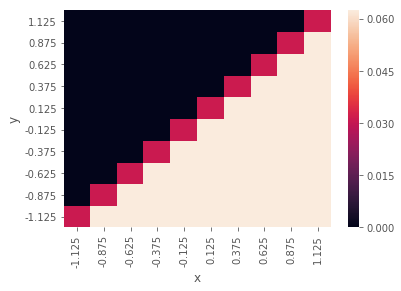

In [22]:
data = {'x': points[:, 0], 'y': points[:, 1], 'area': volume_moments_line[0, 0]}
df = pd.DataFrame(data=data)
pivot = df.pivot(index='y', columns='x', values='area')
ax = sns.heatmap(pivot)
ax.invert_yaxis()